In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'


In [3]:
!wget $data -O data-week-4.csv

--2025-10-22 09:15:15--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: 'data-week-4.csv’

data-week-4.csv     100%[===================>]  78,98K  --.-KB/s    in 0,06s   

2025-10-22 09:15:15 (1,34 MB/s) - 'data-week-4.csv’ saved [80876/80876]



In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# 1) загрузка
df = pd.read_csv("data-week-4.csv")

# целевая колонка: converted (0/1)
y = df["converted"].astype(int)
X = df.drop(columns=["converted"]).copy()

# 2) обработка пропусков
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

if cat_cols:
    X[cat_cols] = X[cat_cols].fillna("NA")
if num_cols:
    X[num_cols] = X[num_cols].fillna(0.0)

# 3) сплит 60/20/20 (сначала отделим test 20%, затем из оставшегося возьмём val 25% = 20% от общего)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=1, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=1, stratify=y_temp
)

# 4) Задание 1 — AUC по одиночным числовым фичам
candidates = ["lead_score", "number_of_courses_viewed", "interaction_count", "annual_income"]
available = [c for c in candidates if c in X_train.columns]

auc_by_feat = {}
for col in available:
    x = X_train[col].astype(float).values
    # базовый AUC
    auc = roc_auc_score(y_train, x)
    # если < 0.5, переворачиваем (эквивалент "минус" на фичу)
    if auc < 0.5:
        auc = 1 - auc
    auc_by_feat[col] = auc

print("AUC по фичам (train):")
for k, v in auc_by_feat.items():
    print(f"{k:>28s}: {v:.6f}")

best_feature = max(auc_by_feat, key=auc_by_feat.get)
print("\nЛучшая фича по AUC:", best_feature)


AUC по фичам (train):
                  lead_score: 0.617792
    number_of_courses_viewed: 0.751909
           interaction_count: 0.705731
               annual_income: 0.567474

Лучшая фича по AUC: number_of_courses_viewed


Q2 AUC(val) = 0.900158  -> выбери 0.92


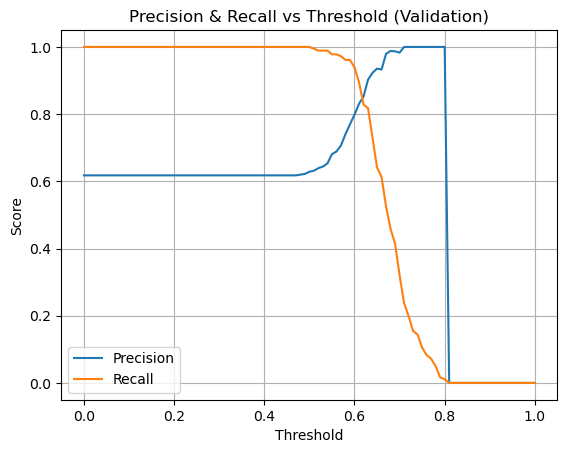

Q3 пересечение Precision≈Recall при ~ 0.810 -> выбери 0.745


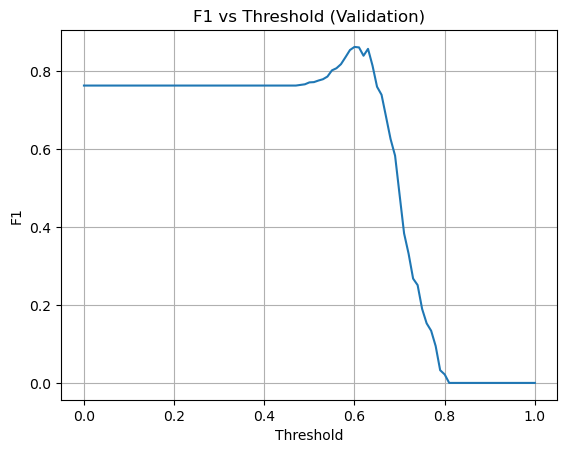

Q4 max F1 при пороге 0.60 -> выбери 0.54
Fold 1: AUC = 0.818095
Fold 2: AUC = 0.835714
Fold 3: AUC = 0.799148
Fold 4: AUC = 0.829971
Fold 5: AUC = 0.814202
Q5 std(AUC) = 0.012781 -> выбери 0.0060
C=1e-06: mean=0.565, std=0.050
C=0.001: mean=0.862, std=0.015
C=1: mean=0.819, std=0.013
Q6 лучший C: 0.001  (mean=0.862, std=0.015)


In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# вспомогательные списки колонок из предыдущей ячейки
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

def to_records(df):
    recs = []
    for i in range(len(df)):
        r = {}
        for c in num_cols: r[c] = float(df.iloc[i][c])
        for c in cat_cols: r[c] = str(df.iloc[i][c])
        recs.append(r)
    return recs

def train_lr(X_tr, y_tr, C=1.0):
    dv = DictVectorizer(sparse=True)
    Xdv = dv.fit_transform(to_records(X_tr))
    model = LogisticRegression(solver="liblinear", C=C, max_iter=1000)
    model.fit(Xdv, y_tr.values)
    return dv, model

def transform(dv, X_df):
    return dv.transform(to_records(X_df))

# ---------------- Q2 ----------------
dv, model = train_lr(X_train, y_train, C=1.0)
val_pred = model.predict_proba(transform(dv, X_val))[:, 1]
q2_auc = roc_auc_score(y_val, val_pred)

def closest(value, options):
    return min(options, key=lambda o: abs(o - value))

q2_choice = closest(q2_auc, [0.32, 0.52, 0.72, 0.92])

print(f"Q2 AUC(val) = {q2_auc:.6f}  -> выбери {q2_choice:.2f}")

# ---------------- Q3 ----------------
thresholds = np.arange(0.0, 1.001, 0.01)
precisions, recalls = [], []
for t in thresholds:
    y_hat = (val_pred >= t).astype(int)
    p = precision_score(y_val, y_hat, zero_division=0)
    r = recall_score(y_val, y_hat, zero_division=0)
    precisions.append(p); recalls.append(r)

plt.figure()
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.xlabel("Threshold"); plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold (Validation)")
plt.grid(True); plt.legend(); plt.show()

diff = np.abs(np.array(precisions) - np.array(recalls))
t_intersect = float(thresholds[np.argmin(diff)])
q3_choice = closest(t_intersect, [0.145, 0.345, 0.545, 0.745])
print(f"Q3 пересечение Precision≈Recall при ~ {t_intersect:.3f} -> выбери {q3_choice:.3f}")

# ---------------- Q4 ----------------
f1s = []
for p, r in zip(precisions, recalls):
    f1s.append(0.0 if (p + r) == 0 else 2 * p * r / (p + r))

plt.figure()
plt.plot(thresholds, f1s)
plt.xlabel("Threshold"); plt.ylabel("F1")
plt.title("F1 vs Threshold (Validation)")
plt.grid(True); plt.show()

idx_best = int(np.argmax(f1s))
t_f1_best = float(thresholds[idx_best])
q4_choice = closest(t_f1_best, [0.14, 0.34, 0.54, 0.74])
print(f"Q4 max F1 при пороге {t_f1_best:.2f} -> выбери {q4_choice:.2f}")

# ---------------- Q5 ----------------
df_full_train = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
y_full_train = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

kf = KFold(n_splits=5, shuffle=True, random_state=1)

def cv_fold_auc(idx_tr, idx_va, C=1.0):
    X_tr = df_full_train.iloc[idx_tr].reset_index(drop=True)
    y_tr = y_full_train.iloc[idx_tr].reset_index(drop=True)
    X_va = df_full_train.iloc[idx_va].reset_index(drop=True)
    y_va = y_full_train.iloc[idx_va].reset_index(drop=True)
    dv_f, m_f = train_lr(X_tr, y_tr, C=C)
    preds = m_f.predict_proba(transform(dv_f, X_va))[:, 1]
    return roc_auc_score(y_va, preds)

scores = []
for fold, (i_tr, i_va) in enumerate(kf.split(df_full_train), 1):
    s = cv_fold_auc(i_tr, i_va, C=1.0)
    scores.append(s)
    print(f"Fold {fold}: AUC = {s:.6f}")

std_auc = float(np.std(scores))
q5_choice = closest(std_auc, [0.0001, 0.006, 0.06, 0.36])
print(f"Q5 std(AUC) = {std_auc:.6f} -> выбери {q5_choice:.4f}")

# ---------------- Q6 ----------------
grid = [0.000001, 0.001, 1]
cv_res = {}
for C in grid:
    sc = []
    for i_tr, i_va in kf.split(df_full_train):
        sc.append(cv_fold_auc(i_tr, i_va, C=C))
    mean_s = float(np.mean(sc))
    std_s = float(np.std(sc))
    cv_res[C] = (round(mean_s, 3), round(std_s, 3))
    print(f"C={C}: mean={mean_s:.3f}, std={std_s:.3f}")

# выбрать лучший: по наибольшему mean, при равенстве — меньший std, затем — меньший C
best = sorted(cv_res.items(), key=lambda kv: (-kv[1][0], kv[1][1], kv[0]))[0]
best_C = best[0]
print(f"Q6 лучший C: {best_C}  (mean={cv_res[best_C][0]:.3f}, std={cv_res[best_C][1]:.3f})")
